In [ ]:
!pip install kora
import kora.install.py38

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 1.2 MB/s 
     |████████████████████████████████| 1.6 MB 26.9 MB/s 
https://20d1-34-90-125-37.ngrok.io


In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [ ]:
INPUT_PATH = "/content/"

In [ ]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    if os.path.isdir(dir_):
      count = 0
      for f in os.listdir(INPUT_PATH + dir_ + "/"):
          count += 1
          total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

.config has 8 number of images
emo.zip has 8 number of images
Happy has 6834 number of images
Neutral has 4295 number of images
fear has 2535 number of images
epoch_history_mobilenet.png has 2535 number of images
model.png has 2535 number of images
Angry has 2832 number of images
disgust has 380 number of images
sample_data has 6 number of images

total images are 16890


In [ ]:
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images

16510

In [ ]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all Happy images to numpy arrays
loaded all Neutral images to numpy arrays
loaded all fear images to numpy arrays
loaded all Angry images to numpy arrays


((16510, 48, 48, 3),
 array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        2.42092166e-322, 2.12199579e-314, 3.19209882e-314]))

In [ ]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

NameError: ignored

In [ ]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(16510, 4)

In [ ]:
img_arr = img_arr / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14859, 48, 48, 3), (1651, 48, 48, 3), (14859, 4), (1651, 4))

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

In [ ]:
for layer in model.layers[:15]:
    layer.trainable = False

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]


In [ ]:
batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/40


<ipython-input-169-7be4333399cc>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


594/594 [==============================] - 16s 24ms/step - loss: 1.3081 - accuracy: 0.4989 - val_loss: 1.0993 - val_accuracy: 0.5833 - lr: 0.0100
Epoch 2/40
594/594 [==============================] - 13s 21ms/step - loss: 0.9979 - accuracy: 0.6037 - val_loss: 0.9894 - val_accuracy: 0.5893 - lr: 0.0100
Epoch 3/40
594/594 [==============================] - 13s 21ms/step - loss: 0.9068 - accuracy: 0.6344 - val_loss: 0.9851 - val_accuracy: 0.5954 - lr: 0.0100
Epoch 4/40
594/594 [==============================] - 13s 21ms/step - loss: 0.8760 - accuracy: 0.6516 - val_loss: 0.9041 - val_accuracy: 0.6511 - lr: 0.0100
Epoch 5/40
594/594 [==============================] - 13s 21ms/step - loss: 0.8668 - accuracy: 0.6573 - val_loss: 0.8967 - val_accuracy: 0.6360 - lr: 0.0100
Epoch 6/40
594/594 [==============================] - 13s 21ms/step - loss: 0.8393 - accuracy: 0.6676 - val_loss: 0.9519 - val_accuracy: 0.6021 - lr: 0.0100
Epoch 7/40
594/594 [==============================] - 15s 25ms/step -

In [ ]:
model_yaml = model.to_json() 
with open("model_mobelnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_moblenet.h5")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

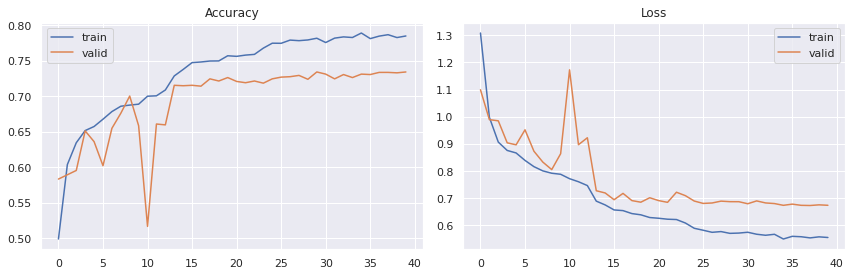

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [ ]:
# Code reference: https://www.kaggle.com/code/sarthak3398/emotion-detection-using-transferlearning 

# https://www.kaggle.com/code/gauravsharma99/facial-emotion-recognition-using-transfer-learning